In [2]:
# Example: Custom Layout Pass with NetworkX for VQE or GHZ optimization

from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap, Layout, PassManager, TransformationPass
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.transpiler.passes import SetLayout,VF2Layout
import qiskit_ibm_runtime.fake_provider as fk  # Example IBM device
import networkx as nx
from qiskit.circuit.library import RealAmplitudes
from qiskit.visualization import plot_circuit_layout, plot_coupling_map
import networkx as nx
from qiskit.transpiler import Layout, CouplingMap

In [15]:
# Example QAOA Circuit for Periodic Ising Chain
def qaoa_ising_periodic(n, gamma, beta,h=1):
    qc = QuantumCircuit(n)

    #Initial Hadamard layer
    qc.h(range(n))

    #Cost layer (Z terms)
    for i in range(n):
        qc.rz(2 * h, i)  # Apply Z rotation for each qubit

    #Cost layer (ZZ terms) with periodic boundary conditions
    for i in range(n):
        qc.rzz(2 * gamma, i, (i + 1) % n)

    # Mixer layer (X rotations)
    for i in range(n):
        qc.rx(2 * beta, i)

    return qc

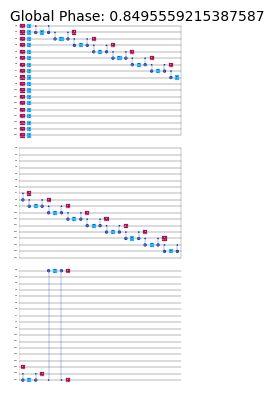

In [16]:
backend= fk.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

# Problem parameters
n = 18  # Logical problem size
gamma = 0.8
beta = 0.4


# Create QAOA Circuit
qc = qaoa_ising_periodic(n, gamma, beta).decompose()
qc.draw('mpl',scale=0.1)

/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_14568/3312384718.py:1: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pass_manager = generate_preset_pass_manager(


circuit depth 101
CNOT count 60


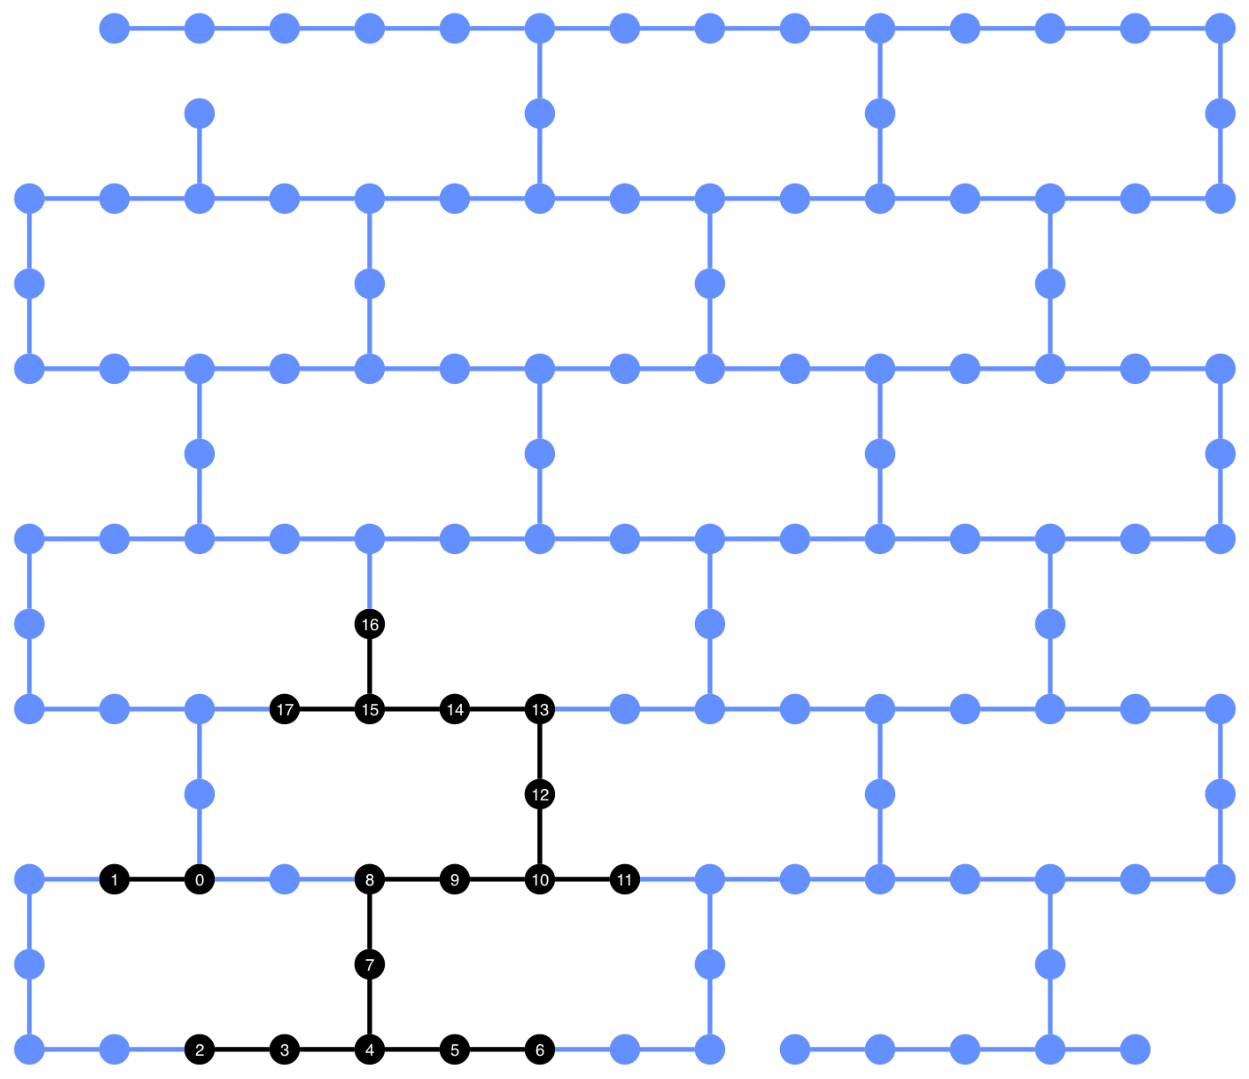

In [17]:
pass_manager = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method='sabre',
        coupling_map=cm)
    
transpiled_circ = pass_manager.run(qc)

print("circuit depth",transpiled_circ.depth())
print("CNOT count",transpiled_circ.count_ops().get("cx", 0))
plot_circuit_layout(transpiled_circ, backend)

In [19]:


def find_best_cycle(coupling_map: CouplingMap, n: int):
    """
    Find exact cycle of length n, else nearest larger cycle.
    """
    G = nx.Graph()
    G.add_edges_from(coupling_map.get_edges())
    cycles = list(nx.cycle_basis(G))

    exact = [c for c in cycles if len(c) == n]
    larger = [c for c in cycles if len(c) > n]

    if exact:
        return exact[0]
    if larger:
        # Pick smallest larger cycle
        return min(larger, key=len)
    return None

def adaptive_ring_layout(logical_qubits: int, coupling_map: CouplingMap):
    """
    Adaptive layout for ring circuits with ancilla if needed.
    """
    cycle = find_best_cycle(coupling_map, logical_qubits)
    if cycle is None:
        raise ValueError("No valid cycles found in hardware coupling map.")

    required_qubits = len(cycle)
    ancilla = required_qubits - logical_qubits

    #layout_dict = {i: cycle[i] for i in range(required_qubits)}
    #layout = Layout(layout_dict)

    return required_qubits, ancilla#, layout



In [20]:
# Create QAOA Circuit
qc = qaoa_ising_periodic(n, gamma, beta).decompose()

# Determine layout and qubits
required_qubits, ancilla_count = adaptive_ring_layout(n, cm)
print(f"Logical qubits: {n}, minimum largest needed for a circle:\
       {required_qubits}, Ancilla: {ancilla_count}")

cycle = find_best_cycle(cm, n)
layout_dict = {qc.qubits[i]: cycle[i] for i in range(n)}
layout_cyclic = Layout(layout_dict)

Logical qubits: 18, minimum largest needed for a circle:       20, Ancilla: 2


/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_14568/1432898409.py:1: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pass_manager = generate_preset_pass_manager(


circuit depth 65
CNOT count 42


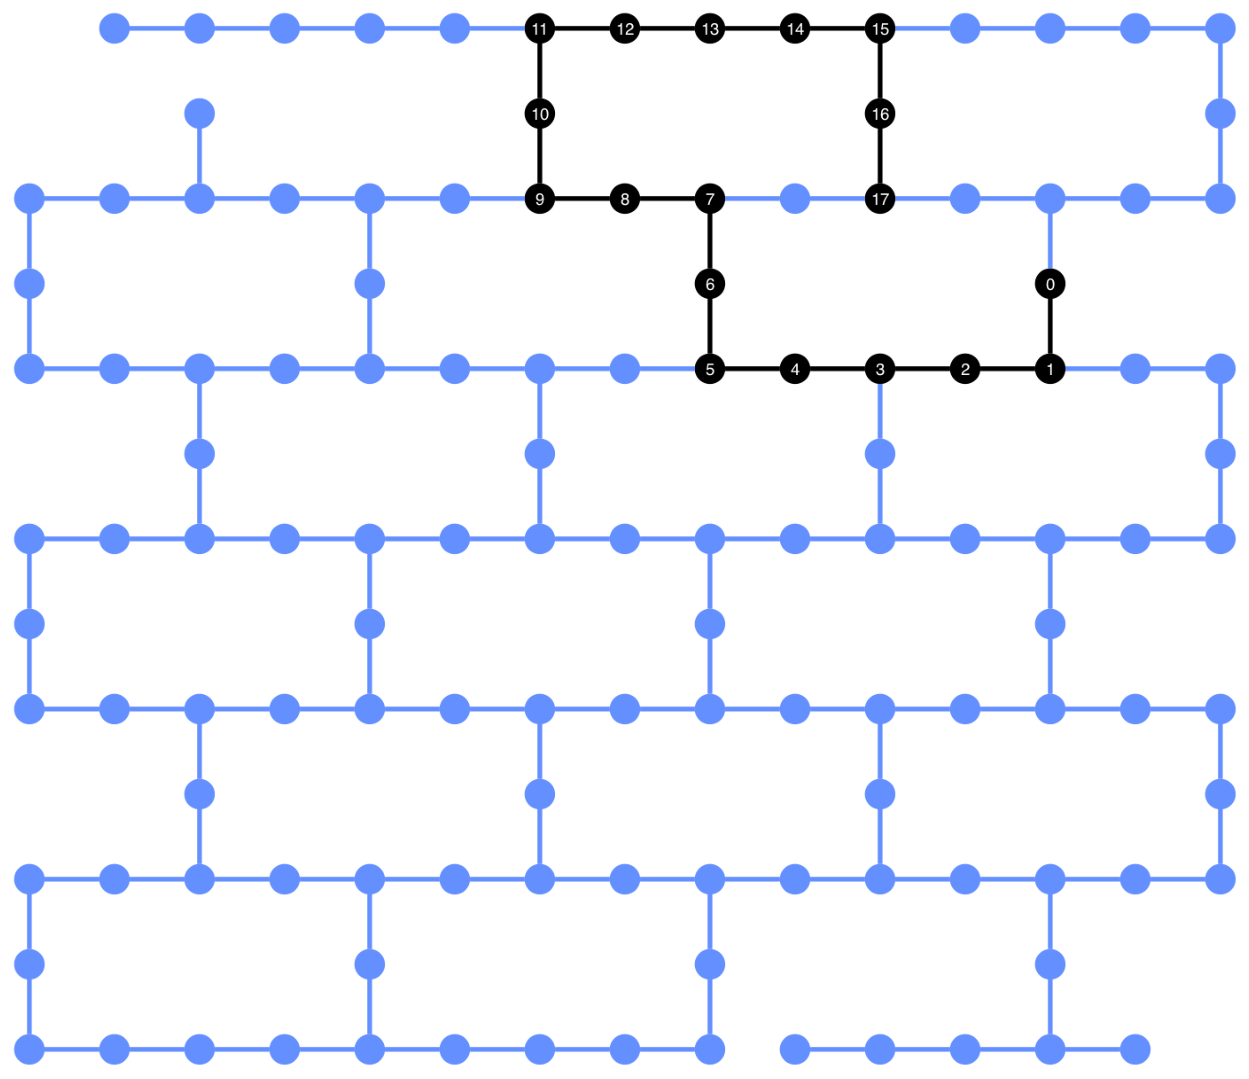

In [13]:
pass_manager = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_cyclic,
        coupling_map=cm)
    
transpiled_circ = pass_manager.run(qc)

print("circuit depth",transpiled_circ.depth())
print("CNOT count",transpiled_circ.count_ops().get("cx", 0))
plot_circuit_layout(transpiled_circ, backend)